In [19]:
# Step 0. Load libraries and custom modules
# Dataframes and matrices ----------------------------------------------
import pandas as pd
import numpy as np
# Graphics -------------------------------------------------------------
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import style
plt.style.use('tableau-colorblind10')
# Mathematical functions -----------------------------------------------
from scipy.stats import norm
# Text processors ------------------------------------------------------
import unicodedata
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from wordcloud import WordCloud
# Preprocessing --------------------------------------------------------
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
# Text modeling --------------------------------------------------------
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
# Model creating -------------------------------------------------------
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
# Metrics --------------------------------------------------------------
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_roc_curve
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import make_scorer
# Custom functions -----------------------------------------------------
from textpreprocessing import clean_stopwords

In [54]:
# We'll use a collection of sentiments for text analysis as a dataset
# This dataset was published in Saif M. Mohammad and Peter Turney. (2013), 
# ``Crowdsourcing a Word-Emotion Association Lexicon.'' 
# Computational Intelligence, 29(3): 436-465.
# It's only for research and educational purposes.
# URL: http://saifmohammad.com/WebPages/lexicons.html  
nrc = pd.read_csv('../data/raw/NRC.csv', names=['word','sentiment','polarity'])
nrc = nrc.query('polarity == 1')

In [55]:
nrc
#Vemos los sentimientos asociados a cada palabra:
# abacus - trust
# abandon - fear
# abandoned - anger

,word,sentiment,polarity
19,abacus,trust,1
23,abandon,fear,1
25,abandon,negative,1
27,abandon,sadness,1
30,abandoned,anger,1
...,...,...,...
141461,zest,anticipation,1
141464,zest,joy,1
141466,zest,positive,1
141469,zest,trust,1


In [56]:
# Step 1. Load the data
# Data extracted from https://www.thetrumparchive.com
# Data case: During the 2016 US presidential election, the candidate 
# Donald Trump used twitter to communicate with potential voters. 
# The campaign was during 2015-06-17 and 2016-11-08
# We'll try to analyze these campaign tweets from iPhone and Android
# Data description
# source -> device of origin
# id_str -> unique identifier
# text -> tweet text content
# created_at -> Date of creation, not including timezone
# retweet_count -> Count of retweets (difusion)
# in_reply_to_usr_id_str -> If it's a reply, grab the user id
# favourite_count -> Count of users that liked the tweet
# is_retweet -> If the post is a retweet  
# 1.1 Open data and get a glimpse
df_raw = pd.read_csv('../data/raw/trump_tweets.csv')
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20761 entries, 0 to 20760
Data columns (total 8 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   source                   20761 non-null  object 
 1   id_str                   20761 non-null  int64  
 2   text                     20761 non-null  object 
 3   created_at               20761 non-null  object 
 4   retweet_count            20761 non-null  int64  
 5   in_reply_to_user_id_str  2442 non-null   float64
 6   favorite_count           20761 non-null  int64  
 7   is_retweet               20761 non-null  bool   
dtypes: bool(1), float64(1), int64(3), object(3)
memory usage: 1.1+ MB


In [57]:
# 1.1 Sample some observations
df_raw.sample(10)

,source,id_str,text,created_at,retweet_count,in_reply_to_user_id_str,favorite_count,is_retweet
14619,Twitter Web Client,573580122516819969,Placing the ball in the right position for the...,2015-03-05T20:25:32Z,79,NaN,105,False
11610,Twitter for Android,452995756962906112,@XenaHer1 Thanks Xena!,2014-04-07T02:26:19Z,1,2.231791e+09,3,False
13315,Twitter Web Client,636601024095109120,.@DennisDMZ Thanks for the nice words. You are...,2015-08-26T18:08:06Z,780,NaN,2024,False
7539,Twitter Web Client,318846641505452032,"In the 10:30 PM ET lead-in to local news, @App...",2013-04-01T22:05:37Z,14,NaN,13,False
8739,Twitter Web Client,301453038835605504,@parisitony Just a small percentage.,2013-02-12T22:09:39Z,6,5.054464e+08,2,False
8825,Mobile Web (M5),299866129067819009,See the Ashley Judd ad by @karlrove and you wi...,2013-02-08T13:03:51Z,31,NaN,14,False
1258,Twitter Web Client,276040994552700928,Great defense by the @nyjets this weekend—cong...,2012-12-04T19:11:16Z,38,NaN,13,False
10089,Twitter Web Client,530485315715469313,“You just can't beat the person who never give...,2014-11-06T22:22:09Z,464,NaN,395,False
9849,Twitter Web Client,544573067503370240,Looking forward to tonight's conversation w/ D...,2014-12-15T19:21:51Z,17,NaN,30,False
19244,Twitter for iPhone,912101775221706752,Making America Safe is my number one priority....,2017-09-24T23:49:43Z,23365,NaN,99043,False


In [58]:
# Step 2. Transform and wrangle the data
# 2.1 Make a copy
df_interim = df_raw.copy()

In [59]:
# 2.2 Get rid of uninformative columns
df_interim = df_interim.drop(['id_str','is_retweet','in_reply_to_user_id_str'], axis=1)

In [60]:
# 2.3 Convert columns to the right format
df_interim['created_at'] = df_interim['created_at'].astype('datetime64')
df_interim['source'] = pd.Categorical(df_interim['source'])

In [61]:
# 2.4 Filter dates for analysis
df_interim = df_interim.loc[(df_interim['created_at'] >= '2015-06-17') \
    & (df_interim['created_at'] <= '2016-11-08')]

In [62]:
# 2.5 Consider time is UTC, convert to EST
df_interim['created_at'] += pd.Timedelta(-5, unit = 'h')
#UTC y EST tienen 5 horas de diferencia, por eso -5

In [63]:
# 2.5 Filter source for analysis
df_interim = df_interim.loc[(df_interim['source'].str.contains('iPhone')) \
    | (df_interim['source'].str.contains('Android'))]
df_interim['source'] = df_interim['source'].cat.remove_unused_categories()

#Filtramos solo los tweets provenientes del iPhone o Androd de Trump

In [64]:
# 2.5 Save and create a copy for analysis
df_interim.to_csv('../data/interim/trump_tweets.csv', index=False)
df = df_interim.copy()

In [65]:
# Step 3. Perform EDA
# 3.1 Get basic info
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3946 entries, 12072 to 18506
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   source          3946 non-null   category      
 1   text            3946 non-null   object        
 2   created_at      3946 non-null   datetime64[ns]
 3   retweet_count   3946 non-null   int64         
 4   favorite_count  3946 non-null   int64         
dtypes: category(1), datetime64[ns](1), int64(2), object(1)
memory usage: 158.0+ KB


Vamos a hacer el EDA sobre todo el dataset (porque esto no es ML):

In [66]:
# 3.2 Get a sample
df.sample(10)

,source,text,created_at,retweet_count,favorite_count
16944,Twitter for iPhone,I am getting great credit for my press confere...,2016-05-31 18:17:33,7084,21591
13261,Twitter for Android,.@MeghanMcCain was terrible on @TheFive yester...,2015-09-05 06:56:51,1551,2623
15792,Twitter for iPhone,WHAT THEY ARE SAYING ABOUT MIKE PENCE “DOMINAT...,2016-10-04 20:52:36,6835,21946
18154,Twitter for iPhone,Watch @IvankaTrump show you how easy it is to ...,2016-01-31 13:40:42,2424,5517
18331,Twitter for iPhone,Really disgusting that the failing New York Ti...,2016-01-19 09:44:43,1586,4734
17251,Twitter for iPhone,Agreed! https://t.co/biyldP3CIw,2016-04-27 13:51:08,9490,19830
16994,Twitter for Android,Goofy Senator Elizabeth Warren @elizabethforma...,2016-05-25 07:31:56,4820,15687
12873,Twitter for Android,"It's really cold outside, they are calling it ...",2015-10-19 08:30:30,7369,10741
12386,Twitter for Android,The podium in the Oval Office looks odd! Not g...,2015-12-06 19:58:30,1022,3326
13783,Twitter for Android,Why would Republican candidates want the suppo...,2015-07-04 17:28:56,751,1324


In [67]:
# 3.3 Describe numerical and datetime data
df.describe(datetime_is_numeric=True)

,created_at,retweet_count,favorite_count
count,3946,3946.000000,3946.000000
mean,2016-03-31 07:49:53.323872256,5839.465281,15666.982767
min,2015-06-19 20:03:05,61.000000,167.000000
25%,2015-12-20 18:19:10.500000,2013.250000,5350.000000
50%,2016-03-16 05:29:30.500000,4162.500000,11981.500000
75%,2016-07-25 09:04:26.500000,7807.250000,21527.000000
max,2016-11-07 17:21:53,168765.000000,297281.000000
std,NaN,6156.818896,14650.408743


In [68]:
# 3.4 Describe categorical data
df['source'].value_counts()
#Con esta info no podemos saber si Trump usa iphone o android,
#capaz su equipo twittea con uno y él con otro, o capaz no twittea él nunca

Twitter for iPhone     2099
Twitter for Android    1847
Name: source, dtype: int64

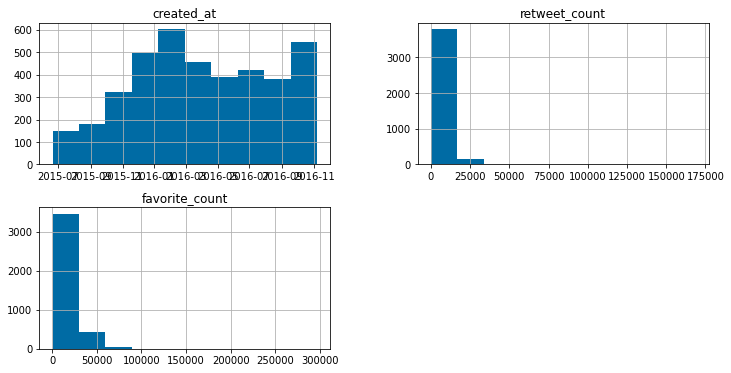

In [69]:
# 3.5 Get histograms for numerical data
df.hist(figsize= (12, 6))
plt.show()

In [71]:
# 3.6 Make a plot of tweets frequence rate by source
#Vamos a hacer un pipeline (serie de pasos)
#1. 'assign' crea una nueva columna que de 'created_at' solo agarra la hora
#2. agrupamos por iphone/android y hora
#3. 'agg' contamos todos los tweets por hora
#4. 'rate' tasa de frecuencia
#5. reset index
df_plot = (df
            .assign(hour = df['created_at'].dt.hour)
            .groupby(['source', 'hour'])
            .agg(count = ('source', 'count'))
            .assign(rate = lambda df: df['count']/df.groupby('source')['count'].sum())
            .reset_index())
df_plot

,source,hour,count,rate
0,Twitter for Android,0,22,0.011911
1,Twitter for Android,1,2,0.001083
2,Twitter for Android,2,6,0.003249
3,Twitter for Android,3,1,0.000541
4,Twitter for Android,4,28,0.015160
5,Twitter for Android,5,98,0.053059
6,Twitter for Android,6,159,0.086086
7,Twitter for Android,7,194,0.105035
8,Twitter for Android,8,210,0.113698
9,Twitter for Android,9,132,0.071467


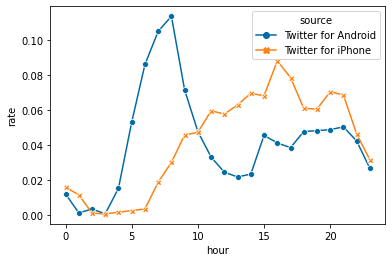

In [72]:
sns.lineplot(data = df_plot, x = 'hour', y = 'rate', hue = 'source', markers = True, style = 'source', dashes = False)
plt.show()

In [73]:
# 3.7 Get a glimpse of the most retweeted tweets
df.sort_values(by='retweet_count', ascending = False)[['text', 'retweet_count']][:10]

,text,retweet_count
16875,How long did it take your staff of 823 people ...,168765
17183,Happy #CincoDeMayo! The best taco bowls are ma...,85465
15333,MAKE AMERICA GREAT AGAIN!,59098
15758,Here is my statement. https://t.co/WAZiGoQqMQ,51891
16548,Such a great honor to be the Republican Nomine...,41616
15340,If Obama worked as hard on straightening out o...,41479
15827,For those few people knocking me for tweeting ...,40850
15756,The media and establishment want me out of the...,40772
16583,I am pleased to announce that I have chosen Go...,38782
16848,Is President Obama going to finally mention th...,38456


In [74]:
# 3.8 Get a glimpse of the most liked tweets
df.sort_values(by='favorite_count', ascending = False)[['text', 'favorite_count']][:10]

,text,favorite_count
16875,How long did it take your staff of 823 people ...,297281
16548,Such a great honor to be the Republican Nomine...,129652
15758,Here is my statement. https://t.co/WAZiGoQqMQ,120244
15781,Mike Pence won big. We should all be proud of ...,120189
17183,Happy #CincoDeMayo! The best taco bowls are ma...,119759
15333,MAKE AMERICA GREAT AGAIN!,115387
15827,For those few people knocking me for tweeting ...,107497
15756,The media and establishment want me out of the...,105680
15340,If Obama worked as hard on straightening out o...,102045
16583,I am pleased to announce that I have chosen Go...,92250


In [75]:
# 3.9 Let's get a glimpse of common words in the tweets' text
df['text'].str.split(expand = True).stack().value_counts()[:10]

the    1965
to     1369
and    1186
I      1133
in     1098
a       987
of      957
is      904
on      829
for     703
dtype: int64

In [76]:
# 3.10 Process text to extract stopwords
df['text_clean'] = df['text'].str.lower()
stop_dict = stopwords.words('english')
df['text_clean'] = df['text_clean'].apply(lambda x: clean_stopwords(x, stop_dict = stop_dict)) 
#clean_stopwords es la función que importamos de textpreprocessing.py
df['text_clean'] = df['text_clean'].str.replace(r'''['!,.]''', '', regex = True)

In [77]:
# 3.11 Extract urls from twitter images
url_pat = 'https://t.co/[A-Za-z\d]+|&amp;'
df['text_clean'] = df['text_clean'].str.replace(url_pat, '', regex = True)

In [78]:
# 3.12 Extract special characters
df['text_clean'] = df['text_clean'].str.replace(r'''[!.,():\-%$/'"']''', '', regex = True)

In [79]:
# 3.13 Extract numbers ##este code está mal
df['text_clean'] = df['text_clean'].str.replace(r'[\d]+', '', regex = True)

In [80]:
# 3.14 See the results
df[['text','text_clean']].sample(10)

,text,text_clean
16940,Crooked Hillary Clinton is a fraud who has put...,crooked hillary clinton fraud put public count...
15790,CLINTON’S FLAILING SYRIA POLICY WAS JUDGED A F...,clinton’s flailing syria policy judged failure...
18086,Everybody is laughing at Jeb Bush-spent $100 m...,everybody laughing jeb bushspent million bott...
13105,I will be the featured guest on the season ope...,featured guest season opener @minutes sunday c...
18193,Thank you for your support!\nhttps://t.co/Mjr8...,thank support httpstcomjrdddrk
18095,We are going to have a big event at the Verizo...,going big event verizon wireless arena manches...
18197,I will take care of the Veterans who have serv...,take care veterans served country bravely #tha...
12236,We're not talking about religion; we're talkin...,were talking religion; were talking security #...
16372,While I am in OH &amp; PA - you can also join ...,oh pa also join @mike_pence nevada mon carso...
13367,Thank you New Hampshire! Together we will Make...,thank new hampshire together make america grea...


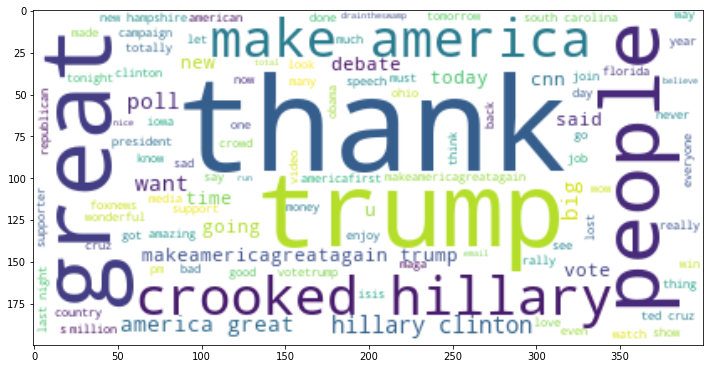

In [81]:
# 3.15 Let's see a wordcloud
text = ' '.join(i for i in df.text_clean)
wordcloud = WordCloud(max_words=100, background_color='White').generate(text)
plt.figure(figsize = (12,12))
plt.imshow(wordcloud, interpolation='bilinear')
plt.show()

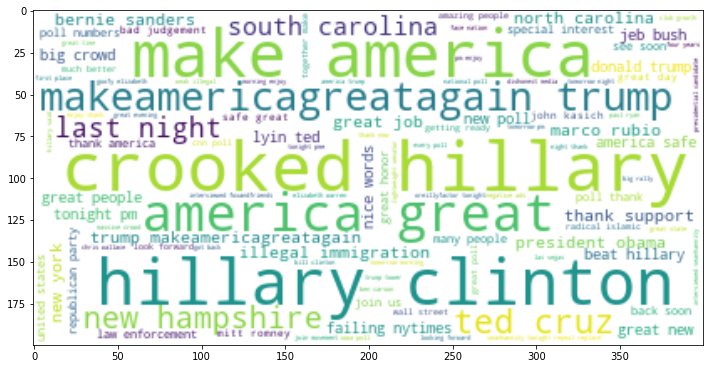

In [82]:
#Bigram, palabras que se repiten juntas
wordcloud_bg = WordCloud(collocation_threshold=2, collocations=True,max_words=100, background_color='White').generate(text) 
plt.figure(figsize = (12,12))
plt.imshow(wordcloud_bg, interpolation='bilinear')
plt.show()

In [84]:
#Vamos a asociar cada palabra con un sentimiento
#Hacemos pipeline:
df_word_split = (df
                .drop(['text', 'created_at', 'retweet_count'], axis = 1)
                .assign(text=df['text_clean'].str.split())).explode('text').drop('text_clean', axis = 1).rename(columns={'text':'word'})
df_word_split

,source,favorite_count,word
12072,Twitter for Android,16495,would
12072,Twitter for Android,16495,like
12072,Twitter for Android,16495,wish
12072,Twitter for Android,16495,everyone
12072,Twitter for Android,16495,happy
...,...,...,...
18506,Twitter for Android,6735,together
18506,Twitter for Android,6735,make
18506,Twitter for Android,6735,america
18506,Twitter for Android,6735,great


In [85]:
#Hacemos join
df_word_split.merge(nrc[['word','sentiment']], on='word', how='inner')

,source,favorite_count,word,sentiment
0,Twitter for Android,16495,happy,anticipation
1,Twitter for Android,16495,happy,joy
2,Twitter for Android,16495,happy,positive
3,Twitter for Android,16495,happy,trust
4,Twitter for iPhone,8416,happy,anticipation
...,...,...,...,...
17547,Twitter for Android,5458,stiff,negative
17548,Twitter for Android,5802,embarrassment,fear
17549,Twitter for Android,5802,embarrassment,negative
17550,Twitter for Android,5802,embarrassment,sadness


In [89]:
df_sent = df_word_split.\
    merge(nrc[['word','sentiment']], on='word', how='inner').\
    groupby(['source', 'sentiment']).agg(count=('sentiment', 'count')).\
    reset_index().pivot_table(index=['sentiment'],columns=['source'], values='count').\
    reset_index().\
    rename(columns={'Twitter for Android': 'Android', 'Twitter for iPhone': 'iPhone'})

df_sent
#Los backslashes permiten hacer mulitilnea
#El celu con más sentimiento de enojo es android

source,sentiment,Android,iPhone
0,anger,949,514
1,anticipation,986,725
2,disgust,632,307
3,fear,815,477
4,joy,743,543
5,negative,1671,925
6,positive,1963,1522
7,sadness,911,512
8,surprise,587,385
9,trust,1363,1022


In [90]:
#Frecuencias relativas | Odd ratio
df_odd_ratio = df_sent.\
    assign(odd_ratio = (df_sent['Android']/(df_sent['Android'].sum()-df_sent['Android']))/(df_sent['iPhone']/(df_sent['iPhone'].sum()-df_sent['iPhone'])))

#Creamos columna con el logaritmo de odd ratio
df_odd_ratio['log_or'] = np.log(df_odd_ratio['odd_ratio'])

In [92]:
df_odd_ratio.sort_values(by = 'log_or', ascending = False)
#Todos los log_or positivos corresponden a Android
#El android (log_or positivo) tiene sentimientos negativos
#Todos los log_or negativos son iPhone y los sentimientos son positivos
#Con esto podríamos deducir que detrás de cada dispotivio hay personas distintas
#Los de iPhone probablemente sean el equipo de campaña de Trump 

source,sentiment,Android,iPhone,odd_ratio,log_or
2,disgust,632,307,1.365482,0.311508
0,anger,949,514,1.225269,0.203160
5,negative,1671,925,1.212601,0.192767
7,sadness,911,512,1.176546,0.162583
3,fear,815,477,1.124833,0.117634
8,surprise,587,385,0.994922,-0.005091
4,joy,743,543,0.885109,-0.122044
1,anticipation,986,725,0.876222,-0.132136
9,trust,1363,1022,0.851456,-0.160808
6,positive,1963,1522,0.806001,-0.215670


In [94]:
#Vamos a calcular intervalos de confianza

#Standard error para odd ratio:
df_odd_ratio['se'] = np.sqrt(1/df_odd_ratio['Android']+1/(df_odd_ratio['Android'].sum()-df_odd_ratio['Android'])+1/df_odd_ratio['iPhone']+1/(df_odd_ratio['iPhone'].sum()-df_odd_ratio['iPhone']))

#Ahora sí podemos calcular intervalos de confianza:
df_odd_ratio['conf_low'] = df_odd_ratio['log_or']-norm.ppf(0.975)*df_odd_ratio['se']
df_odd_ratio['conf_high'] = df_odd_ratio['log_or']+norm.ppf(0.975)*df_odd_ratio['se']
df_odd_ratio.sort_values(by = 'log_or', ascending = False)

#El upper and lower bound de los IC para 'disgust' es 0.17 - 0.45
#Si el intervalo de confianza no contiene al 0, es probable que pertenezca a Android 
#y que las emociones estén bien separadas
#Surprise por ej contiene al 0 entonces no podríamos decir que es una característica de iPhone o Android per se

source,sentiment,Android,iPhone,odd_ratio,log_or,se,conf_low,conf_high
2,disgust,632,307,1.365482,0.311508,0.071349,0.171666,0.451349
0,anger,949,514,1.225269,0.203160,0.057083,0.091280,0.315041
5,negative,1671,925,1.212601,0.192767,0.044246,0.106046,0.279489
7,sadness,911,512,1.176546,0.162583,0.057529,0.049828,0.275338
3,fear,815,477,1.124833,0.117634,0.059836,0.000358,0.234910
8,surprise,587,385,0.994922,-0.005091,0.067479,-0.137347,0.127165
4,joy,743,543,0.885109,-0.122044,0.058697,-0.237087,-0.007001
1,anticipation,986,725,0.876222,-0.132136,0.051560,-0.233192,-0.031081
9,trust,1363,1022,0.851456,-0.160808,0.044602,-0.248227,-0.073388
6,positive,1963,1522,0.806001,-0.215670,0.038299,-0.290735,-0.140606


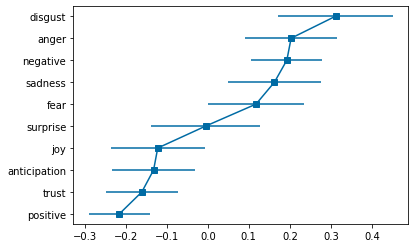

In [97]:
df_odd_ratio = df_odd_ratio.sort_values(by = 'log_or', ascending = True) 
#ordenamos para que el gráfico quede bien

plt.errorbar(df_odd_ratio['log_or'], df_odd_ratio['sentiment'], marker = 's', xerr = ((df_odd_ratio.log_or-df_odd_ratio.conf_low),(df_odd_ratio.conf_high-df_odd_ratio.log_or)))
plt.show()

#graficamos con intervalos de confianza para ver los que están cerca de 0
#disgust está bien lejos del 0 y es característico de android, las cosas más positivas
#están lejos del 0 y son iphone